<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_NN_LDS_to_OccupancyMap_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: NN prediction of Occupancy Map from LDS (v1)
In this first initial network, we create a simple UNet that attempts to reconstruct the occupancy-map from LDS data in 2D coordinates.

We'll be using our single low-res simple floorplan and just create a bunch of samples from it for training data.

In [3]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout afbab9b
!cd repo && git pull

import sys
sys.path.append('repo')

import lds
import lds_train_data
from importlib import reload
reload(lds)
reload(lds_train_data)

Cloning into 'repo'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 112 (delta 46), reused 65 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (112/112), 4.65 MiB | 20.78 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Already up to date.


<module 'lds_train_data' from '/content/repo/lds_train_data.py'>

In [4]:
!pip install -Uqq ipdb

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from PIL import Image
import io
import cv2
import requests
import math
import ipdb
from timeit import default_timer as timer

In [6]:
floorplan = Image.open('repo/data/experimental-floorplan1.png')
floorplan = np.array(floorplan, dtype=bool)
print(f"floorplan: shape={floorplan.shape}, dtype={floorplan.dtype}")

floorplan: shape=(84, 94), dtype=bool


## Training data generation

100%|██████████| 1000/1000 [00:32<00:00, 30.86it/s]


X: 1000 x (105, 105)
Y: 1000 x (105, 105)


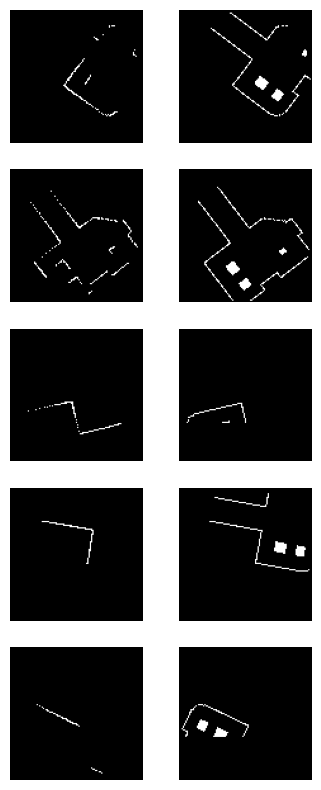

In [7]:
reload(lds_train_data)
np.random.seed(0)
X, Y = lds_train_data.generate_training_data(floorplan, 1000, pixel_size=6.8, max_distance=350)
print(f"X: {len(X)} x {X[0].shape}")
print(f"Y: {len(Y)} x {Y[0].shape}")

# show first 5
plt.figure(figsize=(4, 10))
for i in range(0,5):
  plt.subplot(5,2,i*2+1)
  plt.imshow(X[i], cmap='gray')
  plt.axis('off')

  plt.subplot(5,2,i*2+2)
  plt.imshow(Y[i], cmap='gray')
  plt.axis('off')
plt.show()

In [8]:
# Wrap in a dataset
dataset = tf.data.Dataset.from_tensor_slices((X, Y))

# Simple UNet
An initial version based very heavily on MIT's Deep Learning Specialization, C4W3A2.

In [9]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block.

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(filters=n_filters, # Number of filters
                  kernel_size=(3,3),   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(filters=n_filters, # Number of filters
                  kernel_size=(3,3),   # Kernel size
                  activation='relu',
                  padding='same',
                  # set 'kernel_initializer' same as above
                  kernel_initializer='he_normal')(conv)

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv

    skip_connection = conv
    return next_layer, skip_connection

In [10]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
    """

    up = Conv2DTranspose(
                 filters=n_filters,    # number of filters
                 kernel_size=(3,3),    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,            # Number of filters
                 kernel_size=(3,3),     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,          # Number of filters
                 kernel_size=(3,3),   # Kernel size
                 activation='relu',
                 padding='same',
                  # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(conv)

    return conv

In [11]:
2**5

32

In [12]:
def unet_model(input_size, n_filters, n_classes):
    """
    Unet model.

    Has 4 2x2 downsampling blocks matched up with 4 2x2 upsampling blocks.
    The input dimensions must be multiples of 2**4 = 16 or off-by-one errors
    will occur.

    Arguments:
        input_size (x, y, channels) -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    # Prepare input
    # (Pad up to the nearest multiple of 16 if needed)
    inputs = Input(input_size)
    pad_h = 16 - input_size[0] % 16
    pad_w = 16 - input_size[1] % 16
    print(f"Input size: {input_size}")
    if pad_h > 0 or pad_w > 0:
      print(f"Added padding: w={pad_w}, h={pad_h}")
      padded_inputs = ZeroPadding2D(padding=((pad_h//2, pad_h-pad_h//2), (pad_w//2, pad_w-pad_w//2)))(inputs)
    else:
      padded_inputs = inputs

    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(padded_inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block.
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer.
    # At each step, use half the number of filters of the previous block
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(filters=n_classes, kernel_size=(1,1), padding='same')(conv9)

    outputs = conv10
    if pad_h > 0 or pad_w > 0:
      print(f"Added final cropping: w={pad_w}, h={pad_h}")
      outputs = Cropping2D(cropping=((pad_h//2, pad_h-pad_h//2), (pad_w//2, pad_w-pad_w//2)))(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
input_size = (X[0].shape[0], X[0].shape[1], 1)
n_filters=32
n_classes=2

unet = unet_model(input_size, n_filters, n_classes)
unet.summary()

Input size: (105, 105, 1)
Added padding: w=7, h=7
Added final cropping: w=7, h=7
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 105, 105, 1)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 112, 112, 1)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         320       ['zero_padding2d[0][0]']      
                                                                                                  
 conv2d_1 (Co

In [14]:
# Runs in a couple of minutes on TPU
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 5
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size)
print(train_dataset.element_spec)
model_history = unet.fit(train_dataset, epochs=epochs)

(TensorSpec(shape=(None, 105, 105), dtype=tf.bool, name=None), TensorSpec(shape=(None, 105, 105), dtype=tf.bool, name=None))
Epoch 1/5
32/32 [==============================] - 43s 1s/step - loss: 0.4473 - accuracy: 0.9659
Epoch 2/5
32/32 [==============================] - 38s 1s/step - loss: 0.0828 - accuracy: 0.9783
Epoch 3/5
32/32 [==============================] - 38s 1s/step - loss: 0.0794 - accuracy: 0.9789
Epoch 4/5
32/32 [==============================] - 38s 1s/step - loss: 0.0778 - accuracy: 0.9789
Epoch 5/5
32/32 [==============================] - 38s 1s/step - loss: 0.0761 - accuracy: 0.9791


Text(0.5, 1.0, 'Accuracy')

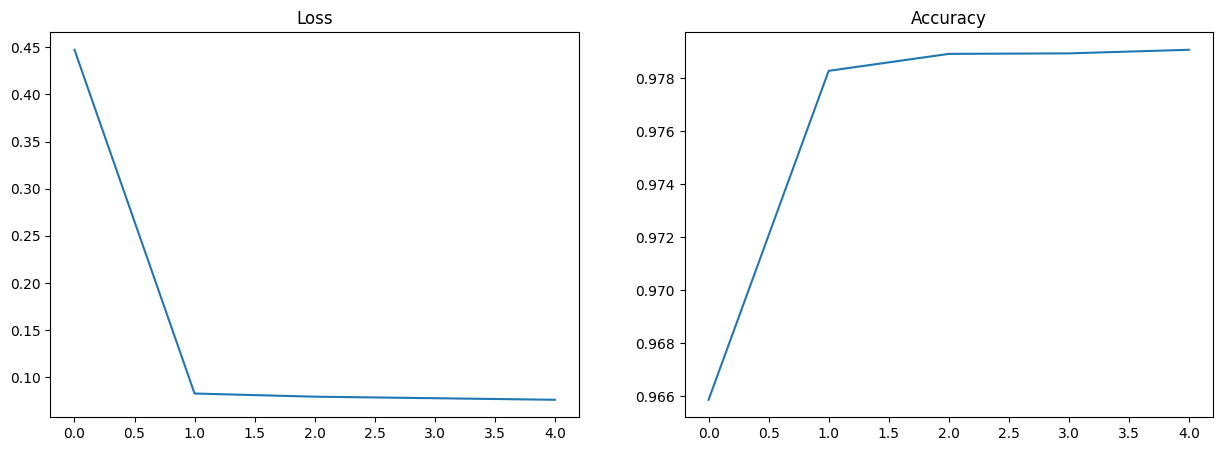

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(model_history.history["loss"])
plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(model_history.history["accuracy"])
plt.title("Accuracy")

In [16]:
# save model to disk for getting back into this later
#unet.save('unet.keras')

# ...or relead
#unet = tf.keras.models.load_model('unet.keras')

## Results

1/1 [==============================] - 0s 47ms/step


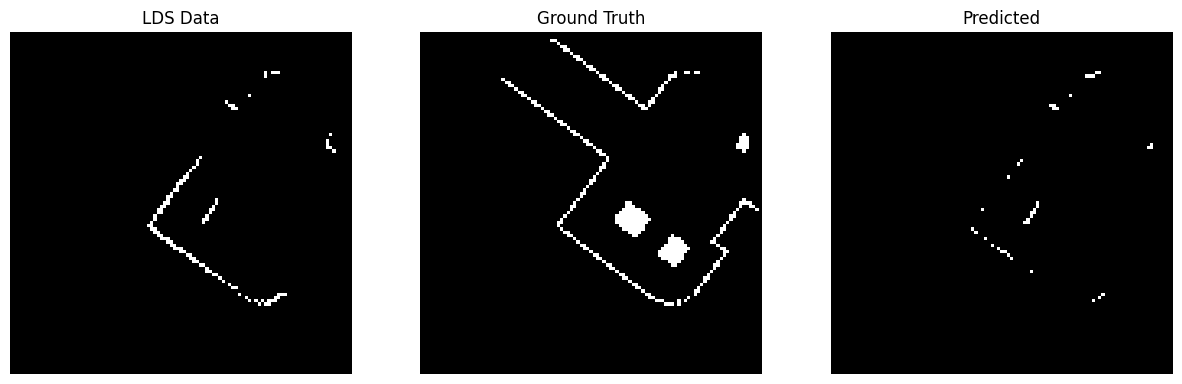

1/1 [==============================] - 0s 46ms/step


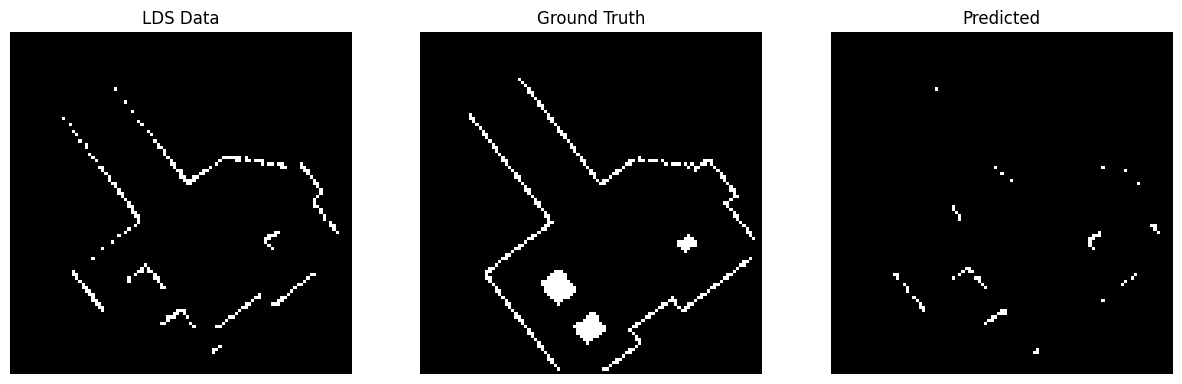

1/1 [==============================] - 0s 48ms/step


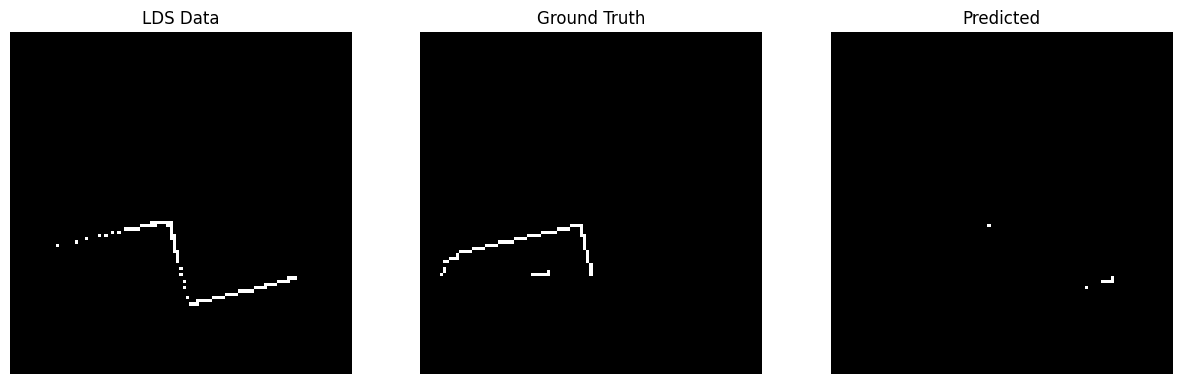

1/1 [==============================] - 0s 46ms/step


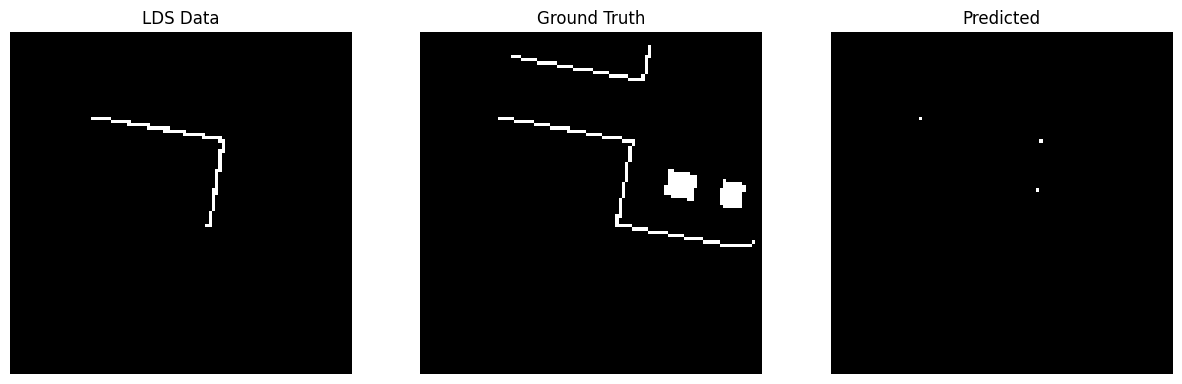

1/1 [==============================] - 0s 46ms/step


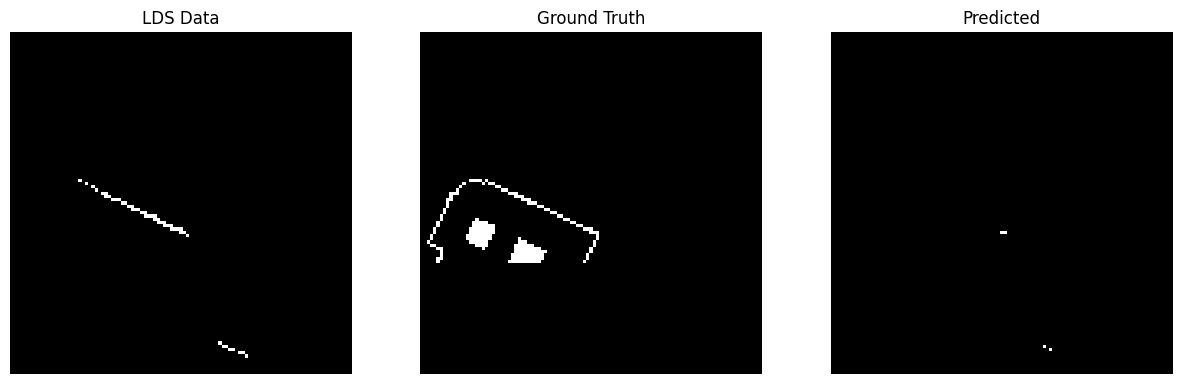

In [42]:
def show_prediction(display_list):
    plt.figure(figsize=(15, 15))

    title = ['LDS Data', 'Ground Truth', 'Predicted']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.axis('off')
    plt.show()

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    for image, ground_truth in dataset.take(num):
        batch = np.expand_dims(image, axis=0)
        batch_pred = unet.predict(batch)
        pred = tf.argmax(batch_pred, axis=-1)[0]
        #print(f"image: {image.shape}, gt: {ground_truth.shape}, batch: {batch.shape}, batch_pred: {batch_pred.shape}, pred: {pred.shape}")
        show_prediction([image, ground_truth, pred])

show_predictions(dataset, 5)

## Learnings
The loss is supposedly very low, and yet the results are terrible.

Poor class balance:
* One problem is that the model doesn't know that there's a very significant difference between the meaning of black and white, but also that there's hugely more black than there is white in the dataset.
* It might be possible to improve that through _importance weighting_.

Single-pixel locations:
* There's another problem that I've been thinking about - that a single pixel that's off by one will receive a full failure, just as much as a single "on" pixel that's way away from anything of significance and which shouldn't be one.
* I can significantly improve the slope of the loss function by considering "on" pixels that are in the right proximity to have close to full reward.
* I think an efficient way to achieve that is to apply a guassian blur to both the ground truth and prediction images and calculate the loss on the blurred images. In the extreme case we could use many levels of blur, ranging from lots to zero, and perhaps even use _curriculum learning_ to change the relative weights of those different blur levels so that by the end it only accepts precise locations.
* Hopefully a simpler form exists that does just as well. It'll need some experimentation.